In [1]:
import os
import torch
from tqdm import tqdm
from glob import glob

#from rembg import remove

from facelandmarks.config import *
from facelandmarks.cropping import *
from facelandmarks.landmarks_utils import *
from facelandmarks.preprocessing import *
from facelandmarks.face_landmarking_model import *
from facelandmarks.training import *
import itertools

In [2]:
# def convert_extension_to_lowercase(folder_path):
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             if file.endswith('.JPG'):
#                 old_path = os.path.join(root, file)
#                 new_name, old_extension = os.path.splitext(file)
#                 new_path = os.path.join(root, f"{new_name}.jpg")

#                 # Rename the file with lowercase extension
#                 os.rename(old_path, new_path)
#                 print(f"Converted {file} extension to lowercase.")

In [6]:
results = {}
projectors = [3]
rotations = [True]
learning_rates = [0.01]
start_out_channels = [8]
num_parents = [10]
ffn_bias = [False]
kernel_sizes = [[3,3,3]]
crop_size = [46]
pooling = [['max', 'avg']]
# template_size = [50]
# gray_scale = [False]
# template_method = ['cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED', 
#                    'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR'] 
# crop_as_template=[True]

hyperparameter_combinations = list(itertools.product(projectors,
                                                     rotations,
                                                     learning_rates,
                                                     num_parents,
                                                     start_out_channels,
                                                     ffn_bias,
                                                     kernel_sizes,
                                                     crop_size,
                                                     pooling))
i = 0
for num_projectors, rotate, lr, num_parent_landmarks, start_out_channels, ffn_bias, kernel_sizes, crop_size, pooling in tqdm(hyperparameter_combinations):
    combination = f"{num_projectors}_{rotate}_{lr}_{num_parent_landmarks}_{start_out_channels}_{ffn_bias}_{kernel_sizes}_{crop_size}_{pooling}"
    model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(num_parent_landmarks=num_parent_landmarks, 
                                                                            projectors=num_projectors, 
                                                                            rotate=rotate, 
                                                                            lr_projection=0.01,
                                                                            lr_cnn=0.001,
                                                                            lr_ffn=lr,
                                                                            start_out_channels=start_out_channels,
                                                                            kernel_sizes=kernel_sizes,
                                                                            activations=False,
                                                                            pooling=pooling,
                                                                            crop_size=crop_size,
                                                                            batch_norm=False,
                                                                            num_cnn=4
                                                                            )
    cache = new_cache() 
    results[combination] = train(
                            model,
                            cache,
                            optimizers,
                            schedulers, 
                            datasets, 
                            dataloaders, 
                            pretrain_epochs=200,
                            cnn_epochs=0,
                            ffn_epochs=0,
                            all_train_epochs=0
                            )
                

  0%|          | 0/1 [00:00<?, ?it/s]

Preparing masks and templates...
Preparing model, optimizers, datasets and dataloaders...
Start training!


100%|██████████| 1/1 [01:15<00:00, 75.61s/it]

In [4]:
dataset = datasets['main']
dataset.pretraining = True
idx = torch.randint(dataset.__len__(),(1,))
batch = dataset.__getitem__(idx)
x, y, multicrop, subimage , image = batch
output, input, subimage = model.predict(image)
display_landmarks(output, subimage, pixel_scale=False, origin='upper_left')

ValueError: not enough values to unpack (expected 5, got 3)

In [7]:
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

for combination, losses in results.items():
    scatter = go.Scatter(
        x=list(range(len(losses['pretrain_cache'])))[50:],
        y=losses['pretrain_cache'][50:],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()

for combination, losses in results.items():
    scatter = go.Scatter(
        x=list(range(len(losses['test_cache']))),
        y=losses['test_cache'],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()

for combination, losses in results.items():
    scatter = go.Scatter(
        x=list(range(len(losses['improvements_cache']))),
        y=losses['improvements_cache'],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [ ]:
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

torch.save(model.state_dict(), model_dir + '/saved_model.pt')

In [ ]:
# Load the model
loaded_model = FaceLandmarking()
model_dir = 'model'
loaded_model.load_state_dict(torch.load(model_dir + '/saved_model.pt'))

# Set the model to evaluation mode
loaded_model.eval()

FaceLandmarking(
  (ensemble): EnsembleProjection(
    (ensemble): ModuleList(
      (0): RawProjection(
        (linear2): Linear(in_features=956, out_features=144, bias=False)
        (loss_func): MSELoss()
      )
    )
  )
  (cnn_ensemble): EnsembleCNN(
    (ensembleCNN): ModuleList(
      (0): CNNFocusing(
        (cnn): Sequential(
          (0): Conv2d(216, 576, kernel_size=(3, 3), stride=(1, 1), groups=72)
          (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (2): Conv2d(576, 1152, kernel_size=(3, 3), stride=(1, 1), groups=72)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(1152, 2304, kernel_size=(3, 3), stride=(1, 1), groups=72)
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (linear1): Linear(in_features=36864, out_features=4608, bias=False)
        (linear2): Linear(in_features=4608, out_features=144, bias=

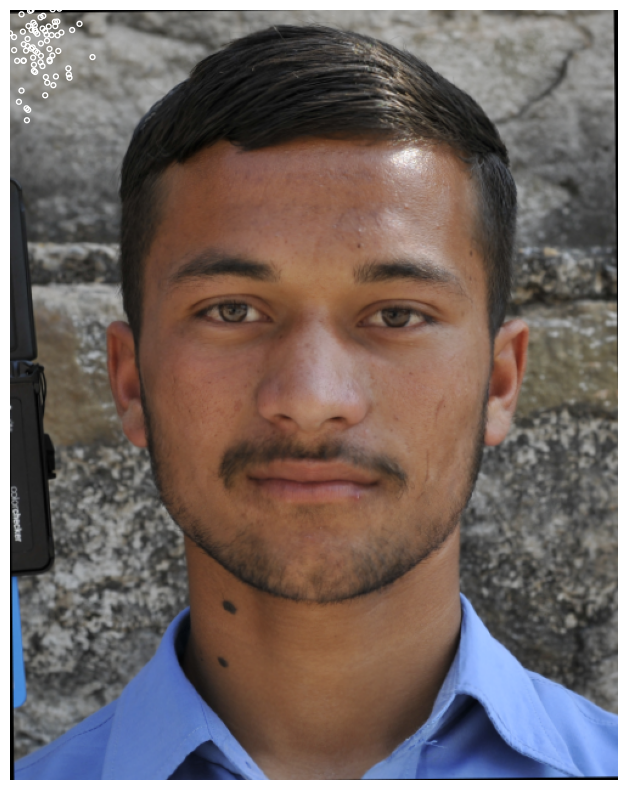

In [ ]:
dataset = datasets['main']
dataset.pretraining = False
dataset.work = True

idx = torch.randint(dataset.__len__(),(1,))
batch = dataset.__getitem__(idx)
x, y, multicrop, subimage , image = batch
output, input, subimage = model.predict(image)
display_landmarks(output, subimage, pixel_scale=False, origin='upper_left')